In [1]:
%matplotlib inline


# Passing networks

Here we look at how to create a passing network and measure
centralisation. Is one player hogging the ball?

..  youtube:: dwJAZY1oJzA
   :width: 640
   :height: 349


Start with the necessary imports.



In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mplsoccer import Pitch, Sbopen
import pandas as pd

## Opening the dataset
The event data is stored in a dataframe *df* as usual.



In [3]:
parser = Sbopen()
df, related, freeze, tactics = parser.event(69301)

## Preparing the data
For passing networks we use only accurate/successful passes made by a team until the first substitution.
This is mainly just to get going and there are several possible variations of this.
We need information about pass start and end location as well as player who made and received the pass. 
To make the vizualisation clearer, we annotate the players using their surname.
(This works for English women side, since players' surnames  are single-barrelled. But
can cause problems.For example, Leo Messi's name in Statsbomb is Lionel Andrés Messi Cuccittini. So the
name Cuccittini will come up if you run this code on his matches!).



In [4]:
#check for index of first sub
sub = df.loc[df["type_name"] == "Substitution"].loc[df["team_name"] == "England Women's"].iloc[0]["index"]
#make df with successfull passes by England until the first substitution
mask_england = (df.type_name == 'Pass') & (df.team_name == "England Women's") & (df.index < sub) & (df.outcome_name.isnull()) & (df.sub_type_name != "Throw-in")
#taking necessary columns
df_pass = df.loc[mask_england, ['x', 'y', 'end_x', 'end_y', "player_name", "pass_recipient_name"]]
#adjusting that only the surname of a player is presented.
df_pass["player_name"] = df_pass["player_name"].apply(lambda x: str(x).split()[-1])
df_pass["pass_recipient_name"] = df_pass["pass_recipient_name"].apply(lambda x: str(x).split()[-1])

## Calculating vertices size and location
To calculate vertices size and location, first we create an empty dataframe.
For each player we calculate average location of passes made and receptions.
Then, we calculate number of passes made by each player.
As the last step, we calculate set he marker size to be proportional to number of passes.



In [5]:
scatter_df = pd.DataFrame()
for i, name in enumerate(df_pass["player_name"].unique()):
    passx = df_pass.loc[df_pass["player_name"] == name]["x"].to_numpy()
    recx = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_x"].to_numpy()
    passy = df_pass.loc[df_pass["player_name"] == name]["y"].to_numpy()
    recy = df_pass.loc[df_pass["pass_recipient_name"] == name]["end_y"].to_numpy()
    scatter_df.at[i, "player_name"] = name
    #make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    #calculate number of passes
    scatter_df.at[i, "no"] = df_pass.loc[df_pass["player_name"] == name].count().iloc[0]

#adjust the size of a circle so that the player who made more passes 
scatter_df['marker_size'] = (scatter_df['no'] / scatter_df['no'].max() * 1500)

## Calculating edges width
To calculate edge width we again look at the number of passes between players
We need to group the dataframe of passes by the combination of passer and recipient and count passes between them.
As the last step, we set the threshold ignoring players that made fewer than 2 passes.
You can try different thresholds and investigate how the passing network changes when you change it.
It is recommended that you tune this depedning on the message behind your visualisation.



In [6]:
#counting passes between players
df_pass["pair_key"] = df_pass.apply(lambda x: "_".join(sorted([x["player_name"], x["pass_recipient_name"]])), axis=1)
lines_df = df_pass.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)
#setting a treshold. You can try to investigate how it changes when you change it.
lines_df = lines_df[lines_df['pass_count']>2]

## Plotting vertices
Lets first plot the vertices (players) using the *scatter_df* we created previously
As the next step, we annotate player's surname   .      



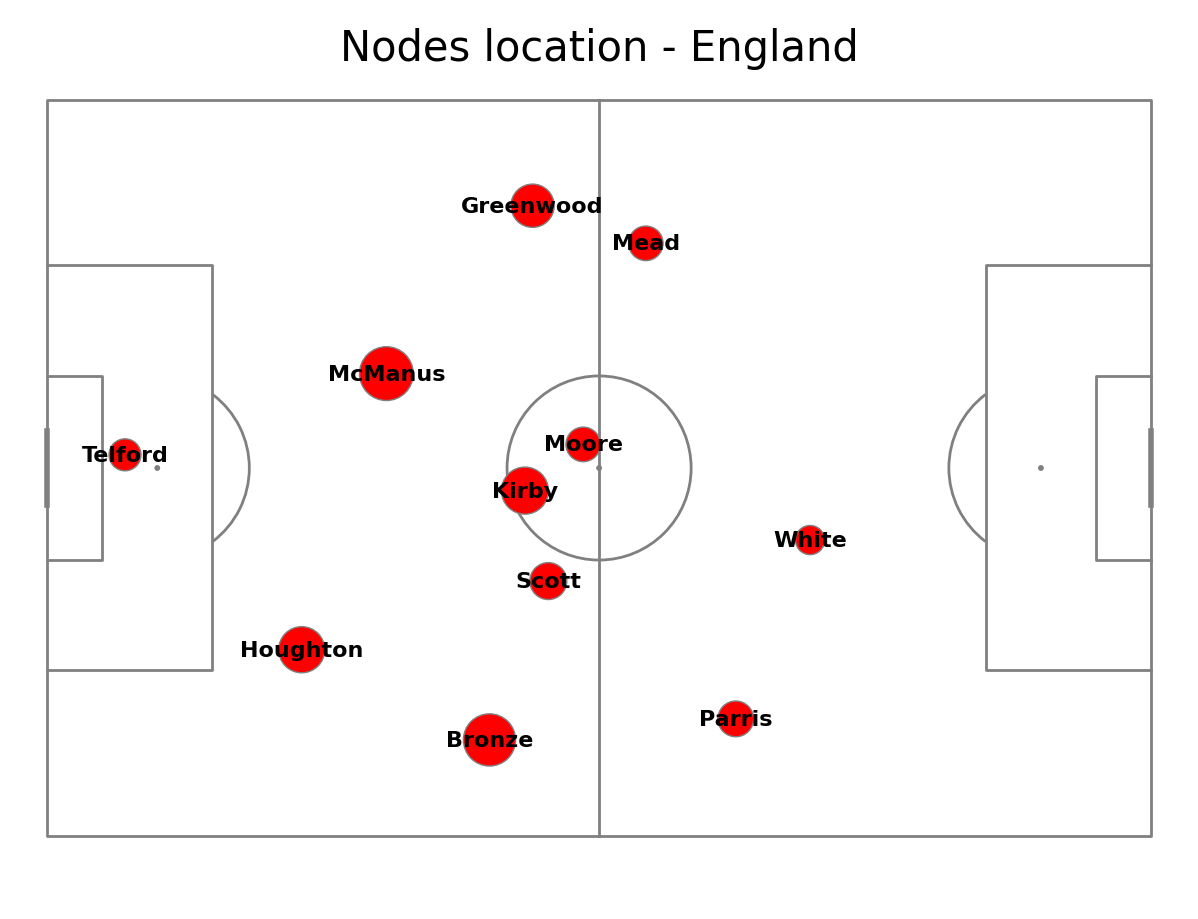

In [7]:
#Drawing pitch
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
#Scatter the location on the pitch
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
#annotating player name
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)

fig.suptitle("Nodes location - England", fontsize = 30)
plt.show()

## Plotting edges
For each combination of players who made passes, we make a query to *scatter_df* to get the start and end of the line.
Then we adjust the line width so that the more passes between players, the wider the line.
As the next step, we plot the lines on the pitch. It is recommended that zorder of edges is lower than zorder of vertices.
In the end, we make the title.



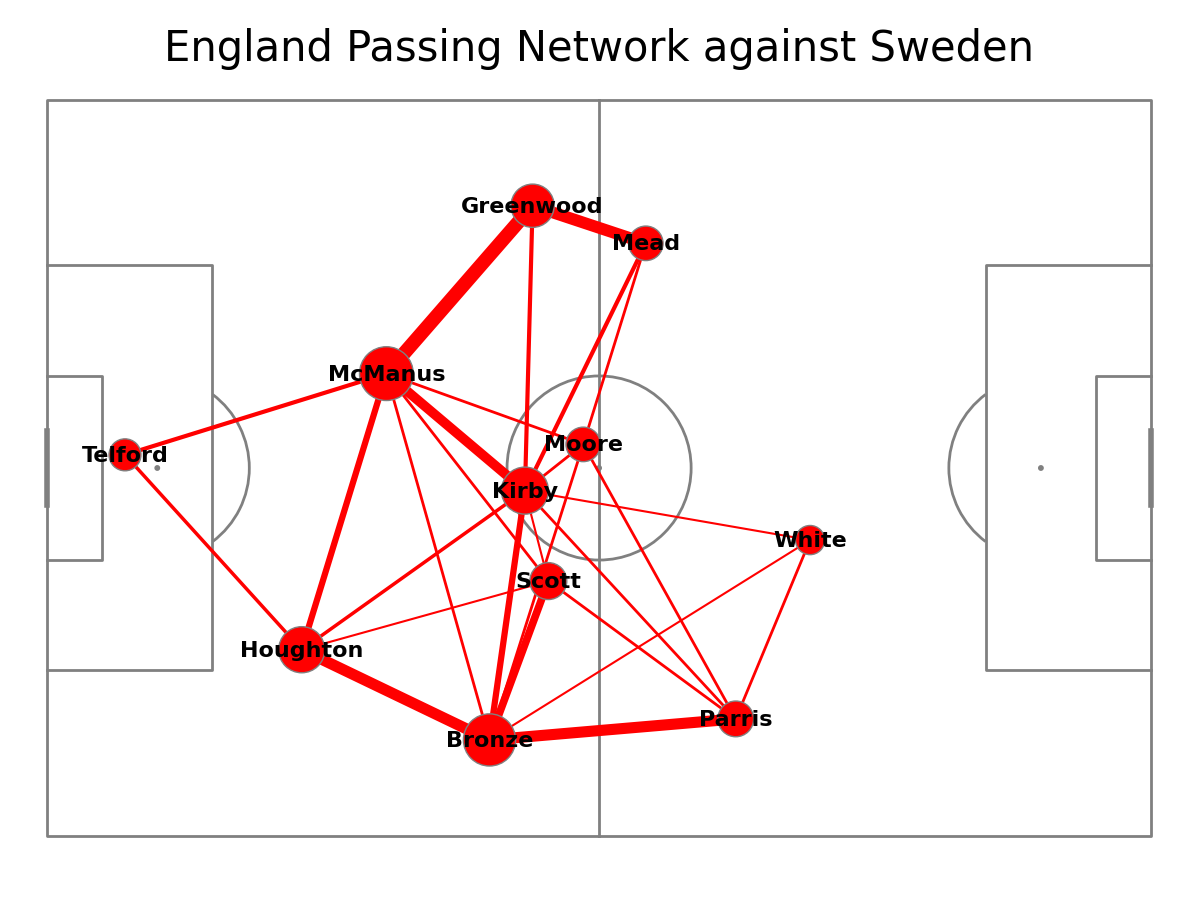

In [8]:
#plot once again pitch and vertices
pitch = Pitch(line_color='grey')
fig, ax = pitch.grid(grid_height=0.9, title_height=0.06, axis=False,
                     endnote_height=0.04, title_space=0, endnote_space=0)
pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color='red', edgecolors='grey', linewidth=1, alpha=1, ax=ax["pitch"], zorder = 3)
for i, row in scatter_df.iterrows():
    pitch.annotate(row.player_name, xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=16, ax=ax["pitch"], zorder = 4)
    
for i, row in lines_df.iterrows():
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]
        #take the average location of players to plot a line between them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]
        #adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 10)
        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=1, lw=line_width, zorder=2, color="red", ax = ax["pitch"])

fig.suptitle("England Passing Network against Sweden", fontsize = 30)
plt.show()

## Centralisation
To calculate the centralisation index we need to calculate number of passes made by each player. 
Then, we calculate the denominator - the sum of all passes multiplied by (number of players - 1) -> 10
To calculate the numerator we sum the difference between maximal number of successful passes by 1 player
and number of successful passes by each player. We calculate the index dividing the numerator by denominator.



In [9]:
#calculate number of successful passes by player
no_passes = df_pass.groupby(['player_name']).x.count().reset_index()
no_passes.rename({'x':'pass_count'}, axis='columns', inplace=True)
#find one who made most passes
max_no = no_passes["pass_count"].max() 
#calculate the denominator - 10*the total sum of passes
denominator = 10*no_passes["pass_count"].sum() 
#calculate the nominator
nominator = (max_no - no_passes["pass_count"]).sum()
#calculate the centralisation index
centralisation_index = nominator/denominator
print("Centralisation index is ", centralisation_index)

Centralisation index is  0.07
